In [ ]:
# CELL 1: INSTALASI LIBRARY & GPU SETUP

!pip install pandas transformers seaborn matplotlib tqdm openpyxl scikit-learn ipywidgets
# Install PyTorch khusus CUDA (GPU)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# CELL 2: IMPORT & KONFIGURASI PATH

import os
import glob
import re
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm.auto import tqdm

# Setup Tampilan Grafik
sns.set_style("whitegrid")
%matplotlib inline

# --- KONFIGURASI FOLDER ---
# Input: Folder Dataset Bersih
INPUT_DATA_PATH = '../DatasetHotelCLEAN' 

# Output: Folder Results Sesuai Struktur Git
# Hasil akan disimpan di: ../Results/CSV/[KategoriHotel]/File.csv
OUTPUT_BASE_PATH = '../Results'
OUTPUT_CSV_PATH = os.path.join(OUTPUT_BASE_PATH, 'CSV') 
OUTPUT_IMG_PATH = os.path.join(OUTPUT_BASE_PATH, 'Visualisasi')

# Buat folder dasar jika belum ada
os.makedirs(OUTPUT_CSV_PATH, exist_ok=True)
os.makedirs(OUTPUT_IMG_PATH, exist_ok=True)

# Kategori Topik untuk AI Zero-Shot (Klasifikasi Aspek)
CANDIDATE_LABELS = [
    "Kualitas Makanan & Restoran",      
    "Kebersihan & Kenyamanan Kamar",    
    "Pelayanan Staf & Keramahan",       
    "Fasilitas Hotel (Kolam/Gym/Spa)",  
    "Lokasi & Akses Strategis",         
    "Infrastruktur (AC/WiFi/Parkir/Air)", 
    "Harga & Value for Money"           
]

print("Konfigurasi Selesai.")
print(f"Input Data: {INPUT_DATA_PATH}")
print(f"Output CSV Root: {OUTPUT_CSV_PATH}")
print(f"  -> Struktur simpan: {OUTPUT_CSV_PATH}/[Kategori]/NamaFile.csv")
print(f"Output Visualisasi: {OUTPUT_IMG_PATH}")

Konfigurasi Selesai.
Input Data: ../DatasetHotelCLEAN
Output CSV Root: ../Results\CSV
  -> Struktur simpan: ../Results\CSV/[Kategori]/NamaFile.csv
Output Visualisasi: ../Results\Visualisasi


In [2]:
# CELL 3: LOAD MODEL AI (OPTIMIZED FOR RTX 3050)

def setup_models():
    print("Memuat Model AI...")
    
    device = 0 if torch.cuda.is_available() else -1
    if device == 0:
        print(f"GPU Terdeteksi: {torch.cuda.get_device_name(0)} (Menggunakan FP16)")
    else:
        print("GPU Tidak Terdeteksi. Menggunakan CPU.")

    # Model IndoBERT (Sentimen) & mDeBERTa (Topik)
    model_sentiment = "w11wo/indonesian-roberta-base-sentiment-classifier"
    model_zeroshot = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

    try:
        # Load pipelines dengan torch_dtype=torch.float16 untuk GPU NVIDIA RTX
        clf_sentiment = pipeline(
            "sentiment-analysis", 
            model=model_sentiment, 
            tokenizer=model_sentiment, 
            device=device,
            torch_dtype=torch.float16 if device == 0 else torch.float32
        )
        
        clf_aspect = pipeline(
            "zero-shot-classification", 
            model=model_zeroshot, 
            device=device,
            torch_dtype=torch.float16 if device == 0 else torch.float32
        )
        
        print("Model Siap Digunakan!")
        return clf_sentiment, clf_aspect
    except Exception as e:
        print(f"Error Load Model: {e}")
        return None, None

# Inisialisasi Model
clf_sentiment, clf_aspect = setup_models()

Memuat Model AI...
GPU Terdeteksi: NVIDIA GeForce RTX 3050 6GB Laptop GPU (Menggunakan FP16)


`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0
Device set to use cuda:0


Model Siap Digunakan!


In [3]:
# CELL 4: FUNGSI INFERENCE AI (BATCH PROCESSING)
from torch.utils.data import Dataset

def process_ai_inference(df, sentiment_model, aspect_model, batch_size=32):
    """
    Menjalankan AI dengan Batch Processing agar jauh lebih cepat.
    """
    if df.empty: return df
    
    # 1. Siapkan Data
    # Kita potong teks maks 512 karakter di awal agar hemat memori
    raw_texts = df['clean_text'].astype(str).tolist()
    texts = [t[:512] for t in raw_texts] 
    
    res_sentiment = []
    res_aspect = []
    
    # 2. Analisis Sentimen (Batching)
    try:
        sent_results = sentiment_model(texts, batch_size=batch_size, truncation=True)
        res_sentiment = [res['label'] for res in sent_results]
    except Exception as e:
        print(f"  [Warning] Error Sentimen Batch: {e}. Fallback ke manual.")
        res_sentiment = ["neutral"] * len(texts)

    # 3. Klasifikasi Aspek (Batching)
    try:
        aspect_results = aspect_model(
            texts, 
            candidate_labels=CANDIDATE_LABELS, 
            batch_size=batch_size, 
            multi_label=False
        )
        res_aspect = [res['labels'][0] for res in aspect_results]
    except Exception as e:
        print(f"  [Warning] Error Aspek Batch: {e}. Fallback ke manual.")
        res_aspect = ["Lainnya"] * len(texts)
            
    # Masukkan hasil prediksi ke DataFrame
    df['AI_Sentiment'] = res_sentiment
    df['AI_Aspek'] = res_aspect
    
    # Bersihkan cache GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    return df

In [4]:
# CELL 5: JALANKAN PROSES PER FILE (OPTIMIZED & FIX DATE)

def run_model_per_file():
    print("\n=== MULAI PROSES AI: MODE PER FILE (BATCHING) ===")
    
    all_files = glob.glob(os.path.join(INPUT_DATA_PATH, "**", "*.csv"), recursive=True)
    processed_dfs = [] 
    
    # Batch Size untuk RTX 3050 6GB (32 biasanya aman dengan FP16)
    BATCH_SIZE = 32 
    
    print(f"Menggunakan Batch Size: {BATCH_SIZE}")

    for i, file_path in enumerate(all_files):
        try:
            filename = os.path.basename(file_path)
            kategori_folder = os.path.relpath(os.path.dirname(file_path), INPUT_DATA_PATH)
            target_folder = os.path.join(OUTPUT_CSV_PATH, kategori_folder)
            os.makedirs(target_folder, exist_ok=True)
            
            print(f"[{i+1}/{len(all_files)}] File: {kategori_folder}/{filename} ...", end=" ")
            
            df = pd.read_csv(file_path)
            
            # --- PERBAIKAN 1: AMBIL TAHUN SAJA ---
            if 'Review Time' in df.columns:
                try:
                    # Konversi ke datetime, lalu ambil tahunnya saja
                    # errors='coerce' akan mengubah data error jadi NaT (kosong), lalu diisi 0 atau dibiarkan
                    df['Review Time'] = pd.to_datetime(df['Review Time'], errors='coerce').dt.year
                except:
                    pass
            # -------------------------------------
            
            # Standardisasi kolom teks
            if 'Review Text' in df.columns: df = df.rename(columns={'Review Text': 'clean_text'})
            elif 'Review Text Cleaned' in df.columns: df = df.rename(columns={'Review Text Cleaned': 'clean_text'})
            
            if df.empty or 'clean_text' not in df.columns: 
                print("SKIP (Data Kosong/Kolom Tidak Ada).")
                continue
            
            # Metadata
            folder_upper = kategori_folder.upper()
            tipe = "KOMPETITOR" if "KOMPETITOR" in folder_upper else "BUMN"
            
            if "B3" in folder_upper: kelas = "Bintang 3"
            elif "B4" in folder_upper: kelas = "Bintang 4"
            elif "B5" in folder_upper: kelas = "Bintang 5"
            else: kelas = "Lainnya"
            
            df['Tipe'] = tipe
            df['Kelas'] = kelas
            df['Nama_Hotel'] = filename.replace('_Clean.csv', '').replace('.csv', '')

            # --- EKSEKUSI AI DENGAN BATCH ---
            df_result = process_ai_inference(df, clf_sentiment, clf_aspect, batch_size=BATCH_SIZE)
            
            # Simpan File
            target_file = os.path.join(target_folder, f"Analisis_{filename}")
            df_result.to_csv(target_file, index=False)
            
            processed_dfs.append(df_result)
            print(f"OK ({len(df)} ulasan).")
            
        except Exception as e:
            print(f"ERROR: {e}")

    print("\nSelesai. Semua file tersimpan.")
    return processed_dfs

# Eksekusi
list_of_dfs = run_model_per_file()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== MULAI PROSES AI: MODE PER FILE (BATCHING) ===
Menggunakan Batch Size: 32
[1/227] File: BUMNB3/Banaran9ResortHotel_Clean.csv ... OK (421 ulasan).
[2/227] File: BUMNB3/BrothersSolo_Clean.csv ... OK (837 ulasan).
[3/227] File: BUMNB3/CodiaBanjarmasin_Clean.csv ... OK (134 ulasan).
[4/227] File: BUMNB3/CordiaBanjarmasin_Clean.csv ... OK (126 ulasan).
[5/227] File: BUMNB3/HAKAHotelSemarang_Clean.csv ... OK (869 ulasan).
[6/227] File: BUMNB3/HarperJakartaMTHaryono_Clean.csv ... OK (1000 ulasan).
[7/227] File: BUMNB3/HotelGrandSurabaya_Clean.csv ... OK (883 ulasan).
[8/227] File: BUMNB3/HotelRattanInn_Clean.csv ... OK (935 ulasan).
[9/227] File: BUMNB3/InnaBaliHeritageHotel_Clean.csv ... OK (693 ulasan).
[10/227] File: BUMNB3/InnaSindhuBeachHotel_Clean.csv ... 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


OK (754 ulasan).
[11/227] File: BUMNB3/InnaTretesHotel_Clean.csv ... OK (852 ulasan).
[12/227] File: BUMNB3/KHASGresikHotel_Clean.csv ... OK (854 ulasan).
[13/227] File: BUMNB3/KHASMakassarHotel (1)_Clean.csv ... OK (857 ulasan).
[14/227] File: BUMNB3/KHASMalioboroHotel (1)_Clean.csv ... OK (948 ulasan).
[15/227] File: BUMNB3/KHASOmbilinHotel_Clean.csv ... OK (324 ulasan).
[16/227] File: BUMNB3/KHASPaluHotel_Clean.csv ... OK (90 ulasan).
[17/227] File: BUMNB3/KHASPekalonganHotel_Clean.csv ... OK (848 ulasan).
[18/227] File: BUMNB3/KHASPekanbaruRiauHotel_Clean.csv ... OK (857 ulasan).
[19/227] File: BUMNB3/KHASPrapat_Clean.csv ... OK (854 ulasan).
[20/227] File: BUMNB3/KHASSemarangHotel_Clean.csv ... OK (886 ulasan).
[21/227] File: BUMNB3/KHASSurabayaHotel_Clean.csv ... OK (851 ulasan).
[22/227] File: BUMNB3/KHASTegalHotel_Clean.csv ... OK (872 ulasan).
[23/227] File: BUMNB3/KHASTuguHotel (1)_Clean.csv ... OK (1073 ulasan).
[24/227] File: BUMNB3/KyriadHotelAirportTanggerang_Clean.csv ..

In [5]:
# CELL 6: PROSES DATA MASTER (SMART RELOAD)

def run_model_master(data_list=None):
    print("\n=== MULAI PENYIMPANAN DATA MASTER ===")
    
    # LOGIKA PINTAR: Cek apakah data di memori ada?
    if not data_list:
        print("Data di memori kosong (Kernel mungkin sudah restart).")
        print("   > Mencoba membaca ulang file hasil 'Analisis_*.csv' dari folder Results...")
        
        # Cari semua file hasil yang sudah pernah disimpan
        # Pola file hasil kita adalah "Analisis_*.csv"
        search_pattern = os.path.join(OUTPUT_CSV_PATH, "**", "Analisis_*.csv")
        found_files = glob.glob(search_pattern, recursive=True)
        
        if not found_files:
            print("Gagal: Belum ada file hasil analisis di folder Results. Jalankan Cell 5 dulu.")
            return pd.DataFrame()
            
        # Baca ulang file-file tersebut ke dalam list
        data_list = []
        for f in tqdm(found_files, desc="   > Membaca ulang file"):
            try:
                data_list.append(pd.read_csv(f))
            except Exception as e:
                print(f"     Gagal baca {os.path.basename(f)}: {e}")
                
        print(f"   > Berhasil memuat ulang {len(data_list)} file dari Disk.")
    else:
        print("Menggunakan data yang masih tersedia di Memori (RAM).")

    # --- PROSES PENGGABUNGAN ---
    if not data_list:
        print("Tidak ada data untuk digabungkan.")
        return pd.DataFrame()

    print("   > Menggabungkan data...")
    master_df = pd.concat(data_list, ignore_index=True)
    
    # Simpan File Master
    path_master = os.path.join(OUTPUT_CSV_PATH, "Analisis_Master_Lengkap.csv")
    master_df.to_csv(path_master, index=False)
    print(f"File Master Disimpan: {path_master}")
    
    # Simpan File Terpisah per Tipe
    df_bumn = master_df[master_df['Tipe'] == 'BUMN']
    if not df_bumn.empty:
        path_bumn = os.path.join(OUTPUT_CSV_PATH, "Analisis_BUMN_All.csv")
        df_bumn.to_csv(path_bumn, index=False)
        print(f"File BUMN All Disimpan: {path_bumn}")
        
    df_komp = master_df[master_df['Tipe'] == 'KOMPETITOR']
    if not df_komp.empty:
        path_komp = os.path.join(OUTPUT_CSV_PATH, "Analisis_KOMPETITOR_All.csv")
        df_komp.to_csv(path_komp, index=False)
        print(f"File Kompetitor All Disimpan: {path_komp}")
        
    print(f"Selesai! Total Data: {len(master_df)} baris")
    return master_df

# Cara Panggil yang Aman:
# Gunakan try-except atau cek variabel
try:
    # Coba pakai data memori jika ada
    df_result = run_model_master(list_of_dfs)
except NameError:
    # Jika variabel list_of_dfs hilang (error), panggil tanpa argumen
    # Fungsi akan otomatis cari file di disk
    df_result = run_model_master()


=== MULAI PENYIMPANAN DATA MASTER ===
Menggunakan data yang masih tersedia di Memori (RAM).
   > Menggabungkan data...
File Master Disimpan: ../Results\CSV\Analisis_Master_Lengkap.csv
File BUMN All Disimpan: ../Results\CSV\Analisis_BUMN_All.csv
File Kompetitor All Disimpan: ../Results\CSV\Analisis_KOMPETITOR_All.csv
Selesai! Total Data: 165948 baris


Grafik 1 Disimpan: ../Results\Visualisasi\1_BUMN_vs_Kompetitor.png


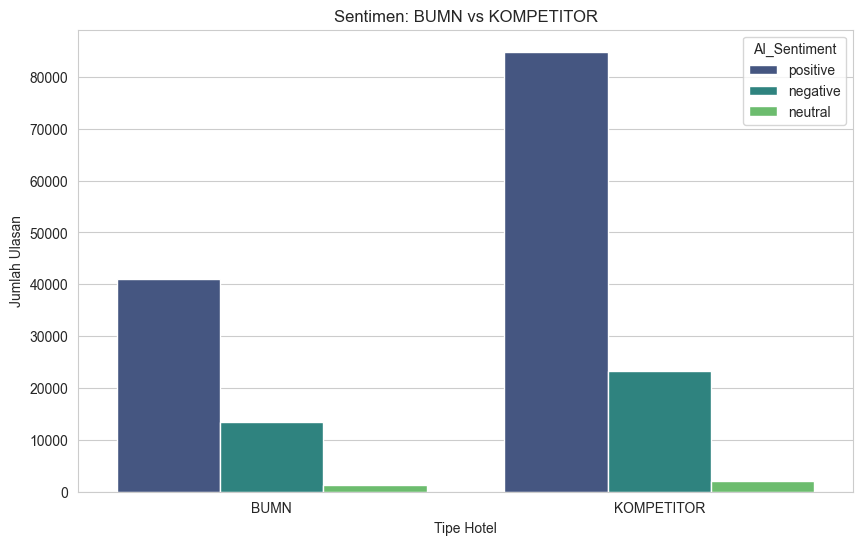

Grafik 2 Disimpan: ../Results\Visualisasi\2_Sentimen_per_Kelas.png


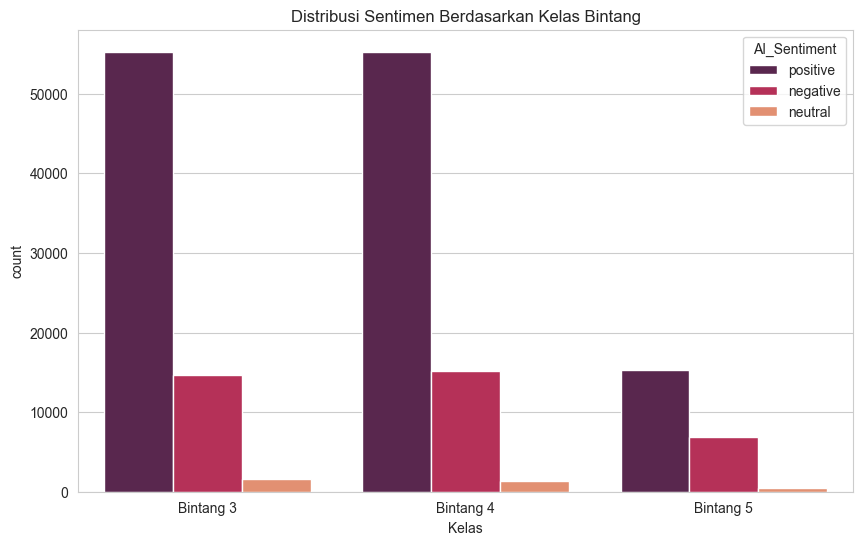

In [6]:
# CELL 7: VISUALISASI & SIMPAN PNG


# Grafik 1: Perbandingan Sentimen
plt.figure(figsize=(10, 6))
sns.countplot(data=df_result, x='Tipe', hue='AI_Sentiment', palette='viridis')
plt.title("Sentimen: BUMN vs KOMPETITOR")
plt.xlabel("Tipe Hotel")
plt.ylabel("Jumlah Ulasan")

# Simpan PNG
path_img1 = os.path.join(OUTPUT_IMG_PATH, "1_BUMN_vs_Kompetitor.png")
plt.savefig(path_img1, dpi=300, bbox_inches='tight')
print(f"Grafik 1 Disimpan: {path_img1}")
plt.show()

# Grafik 2: Sentimen per Kelas Bintang
if 'Kelas' in df_result.columns:
    plt.figure(figsize=(10, 6))
    order = sorted(df_result['Kelas'].unique())
    sns.countplot(data=df_result, x='Kelas', hue='AI_Sentiment', order=order, palette='rocket')
    plt.title("Distribusi Sentimen Berdasarkan Kelas Bintang")
    
    # Simpan PNG
    path_img2 = os.path.join(OUTPUT_IMG_PATH, "2_Sentimen_per_Kelas.png")
    plt.savefig(path_img2, dpi=300, bbox_inches='tight')
    print(f"Grafik 2 Disimpan: {path_img2}")
    plt.show()

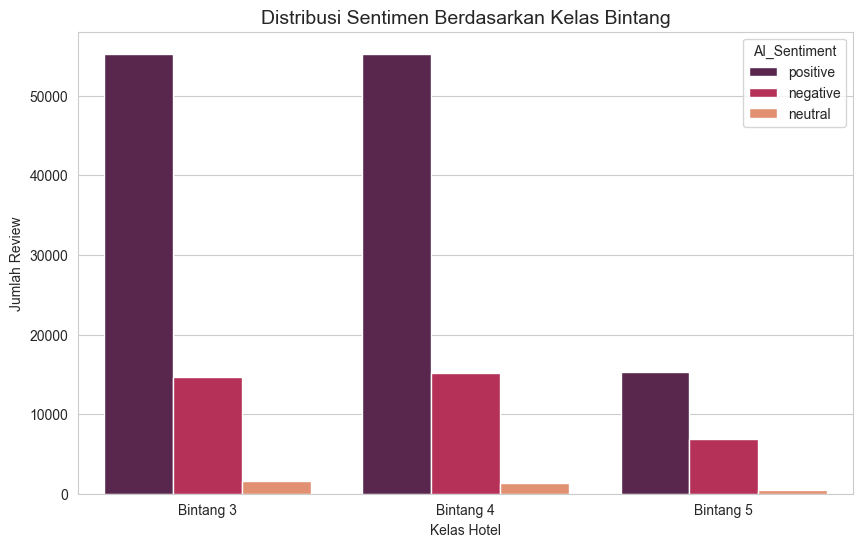

In [7]:
# CELL 8: GRAFIK 2 - PERBANDINGAN KELAS BINTANG

plt.figure(figsize=(10, 6))

try:
    # Urutkan agar grafik rapi (Bintang3 -> Bintang4 -> Bintang5)
    order_bintang = sorted(df_result['Kelas'].unique())
    
    sns.countplot(data=df_result, x='Kelas', hue='AI_Sentiment', order=order_bintang, palette='rocket')
    
    plt.title('Distribusi Sentimen Berdasarkan Kelas Bintang', fontsize=14)
    plt.xlabel('Kelas Hotel')
    plt.ylabel('Jumlah Review')
    plt.show()
except Exception as e:
    print(f"Gagal membuat grafik bintang: {e}")



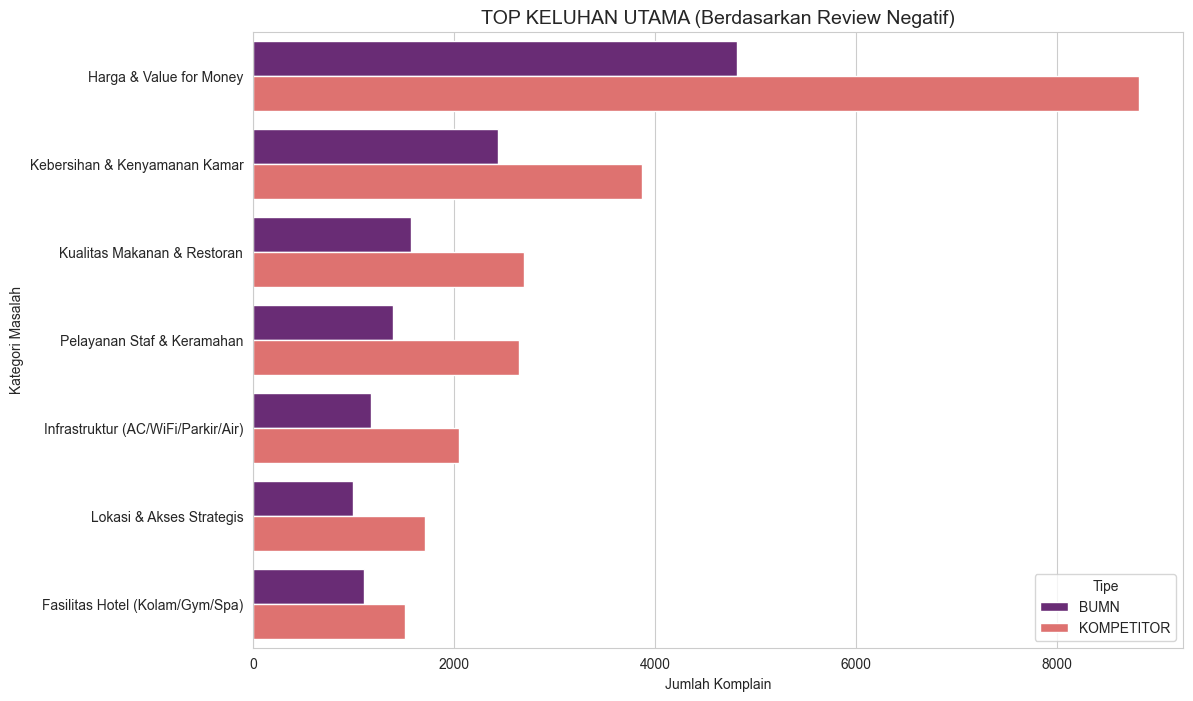

In [8]:
# CELL 9: GRAFIK 3 - PETA MASALAH (Review Negatif Saja)


# Filter: Ambil hanya yang sentimennya NEGATIVE
df_neg = df_result[df_result['AI_Sentiment'] == 'negative']

if not df_neg.empty:
    plt.figure(figsize=(12, 8))
    
    # Hitung aspek mana yang paling banyak dikeluhkan
    order_aspek = df_neg['AI_Aspek'].value_counts().index
    
    # Buat grafik horizontal
    sns.countplot(data=df_neg, y='AI_Aspek', hue='Tipe', order=order_aspek, palette='magma')
    
    plt.title('TOP KELUHAN UTAMA (Berdasarkan Review Negatif)', fontsize=14)
    plt.xlabel('Jumlah Komplain')
    plt.ylabel('Kategori Masalah')
    plt.show()
else:
    print("Wow! Tidak ada review negatif sama sekali.")